<a href="https://colab.research.google.com/github/AzeemWaqarRao/Pytorch_Implementations/blob/main/NameRecognitionRNNPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from io import open
import glob
import os
import unicodedata
import string
import numpy as np
import torch
from torch import nn
import random
import matplotlib.pyplot as plt

In [ ]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [ ]:
# Creating DataSet
def create_dataset():

  names_dict = {}
  data_path = '/content/drive/MyDrive/Names_Data/names'

  for fl in os.listdir(data_path):
    lines = open(os.path.join(data_path,fl),'r').read().strip().split('\n')
    lines = [unicodeToAscii(name) for name in lines]

    lang = fl.split('.')[0]
    names_dict[lang] = lines

  return names_dict


In [ ]:
# helper functions

def letter_encoding(letter):
  vec = torch.zeros((1,n_letters))
  vec[0][int(all_letters.find(letter))] = 1
  return vec

def one_hot(word):
  vec = torch.zeros(len(word),1, n_letters)
  for i, letter in enumerate(word):
    vec[i][0][all_letters.find(letter)] = 1
  return vec

def load_data():
  names_dict = create_dataset()
  return names_dict , list(names_dict.keys())

# def category_from_output(output):
#   _, names = load_data()
#   return names[torch.argmax(output,1)]

def category_from_output(output):
    _, names = load_data()
    category_idx = torch.argmax(output).item()
    return names[category_idx]

def random_choice(seq):
  return seq[random.randint(0,len(seq)-1)]

def get_random_sample(data, categories):
  category = random_choice(categories)
  name = random_choice(data[category])
  category_tensor = torch.tensor([categories.index(category)], dtype=torch.long)
  name_tensor = one_hot(name)
  return name, category, name_tensor, category_tensor


# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


In [ ]:
class RNN(nn.Module):
  def __init__(self,input_len, hidden_len, output_len):
    super(RNN,self).__init__()
    self.hidden_len = hidden_len

    # layers
    self.i2h = nn.Linear(input_len+hidden_len, hidden_len)
    self.i2o = nn.Linear(input_len+hidden_len, output_len)
    self.softmax = nn.LogSoftmax(dim=1) # shape(1,57) so we want to apply softmax along the second dimension

  def forward(self,input,hidden_state):
    input = torch.cat((input,hidden_state),dim=1)

    hidden = self.i2h(input)
    output = self.i2o(input)
    output = self.softmax(output)
    return output, hidden

  def init_hidden(self):
    return torch.zeros(1,self.hidden_len , dtype=torch.float32)

In [ ]:
# getting data

data, category_names = load_data()
n_categories = len(category_names)

In [ ]:
hidden_len = 128
rnn = RNN(n_letters, hidden_len, n_categories)

In [ ]:
# doing one single step for one letter

hidden_len = 128
rnn = RNN(n_letters, hidden_len, n_categories)

input = letter_encoding('G')
hidden = rnn.init_hidden()

output, new_hidden = rnn(input, hidden)

print(output.shape)
print(new_hidden.shape)

torch.Size([1, 18])
torch.Size([1, 128])


In [ ]:
# doing for one name
input_tensor = one_hot('Albert')

rnn = RNN(n_letters, 128, n_categories)
hidden_state = rnn.init_hidden()

for tensor in input_tensor:
  output, hidden_state = rnn(tensor, hidden_state)

print(f"The name is : {category_from_output(output)}")

The name is : Japanese


In [ ]:
## Training The RNN

# loading data
data, categories = load_data()

# initializing parameters
n_letters = len(all_letters)
hidden_len = 128
output_len = len(categories)
lr = 0.005

# initializing the model
rnn = RNN(n_letters, hidden_len, output_len)

# loss and optimizer
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr = lr)

# train function

def train(input_tensor, category_tensor):
  hidden_tensor = rnn.init_hidden()

  for tensor in input_tensor:
    output, hidden_tensor = rnn(tensor, hidden_tensor)

  loss = loss_fn(output, category_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return output, loss.item()


In [ ]:

current_loss = 0
losses = []
n_iters = 100000
plot_steps, print_steps = 1000,1000

for i in range(n_iters):

  name, category, name_tensor, category_tensor = get_random_sample(data,categories)

  output, loss = train(name_tensor,category_tensor)
  current_loss += loss

  if (i+1) % plot_steps == 0:
    losses.append(current_loss / plot_steps)
    current_loss = 0

  if (i+1) % print_steps == 0:
    actual = category_from_output(output)
    state = "CORRECT" if actual == category else f"WRONG loss: {loss}"
    print(state)



CORRECT
CORRECT
CORRECT
WRONG loss: 2.6492373943328857
CORRECT
WRONG loss: 2.8474743366241455
WRONG loss: 2.51224684715271
WRONG loss: 2.4757680892944336
WRONG loss: 2.899132251739502
CORRECT
CORRECT
CORRECT
CORRECT
WRONG loss: 2.129194974899292
WRONG loss: 2.1252622604370117
WRONG loss: 1.5965005159378052
CORRECT
CORRECT
CORRECT
WRONG loss: 1.5822515487670898
CORRECT
CORRECT
WRONG loss: 3.2867493629455566
WRONG loss: 3.6180224418640137
CORRECT
WRONG loss: 1.0208240747451782
WRONG loss: 2.5163049697875977
CORRECT
WRONG loss: 2.354915142059326
CORRECT
CORRECT
CORRECT
WRONG loss: 2.3346190452575684
WRONG loss: 2.6956686973571777
CORRECT
CORRECT
CORRECT
CORRECT
CORRECT
WRONG loss: 3.009779930114746
CORRECT
CORRECT
WRONG loss: 1.810272216796875
WRONG loss: 1.5623154640197754
CORRECT
WRONG loss: 2.3055849075317383
WRONG loss: 2.3471198081970215
WRONG loss: 2.4238429069519043
CORRECT
WRONG loss: 2.066862106323242
CORRECT
WRONG loss: 0.965409517288208
WRONG loss: 1.4576504230499268
WRONG loss

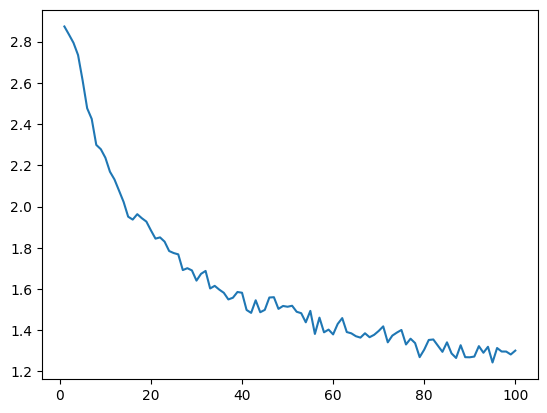

In [ ]:
plt.figure()
plt.plot(range(1, n_iters//plot_steps+1), losses)
plt.show()